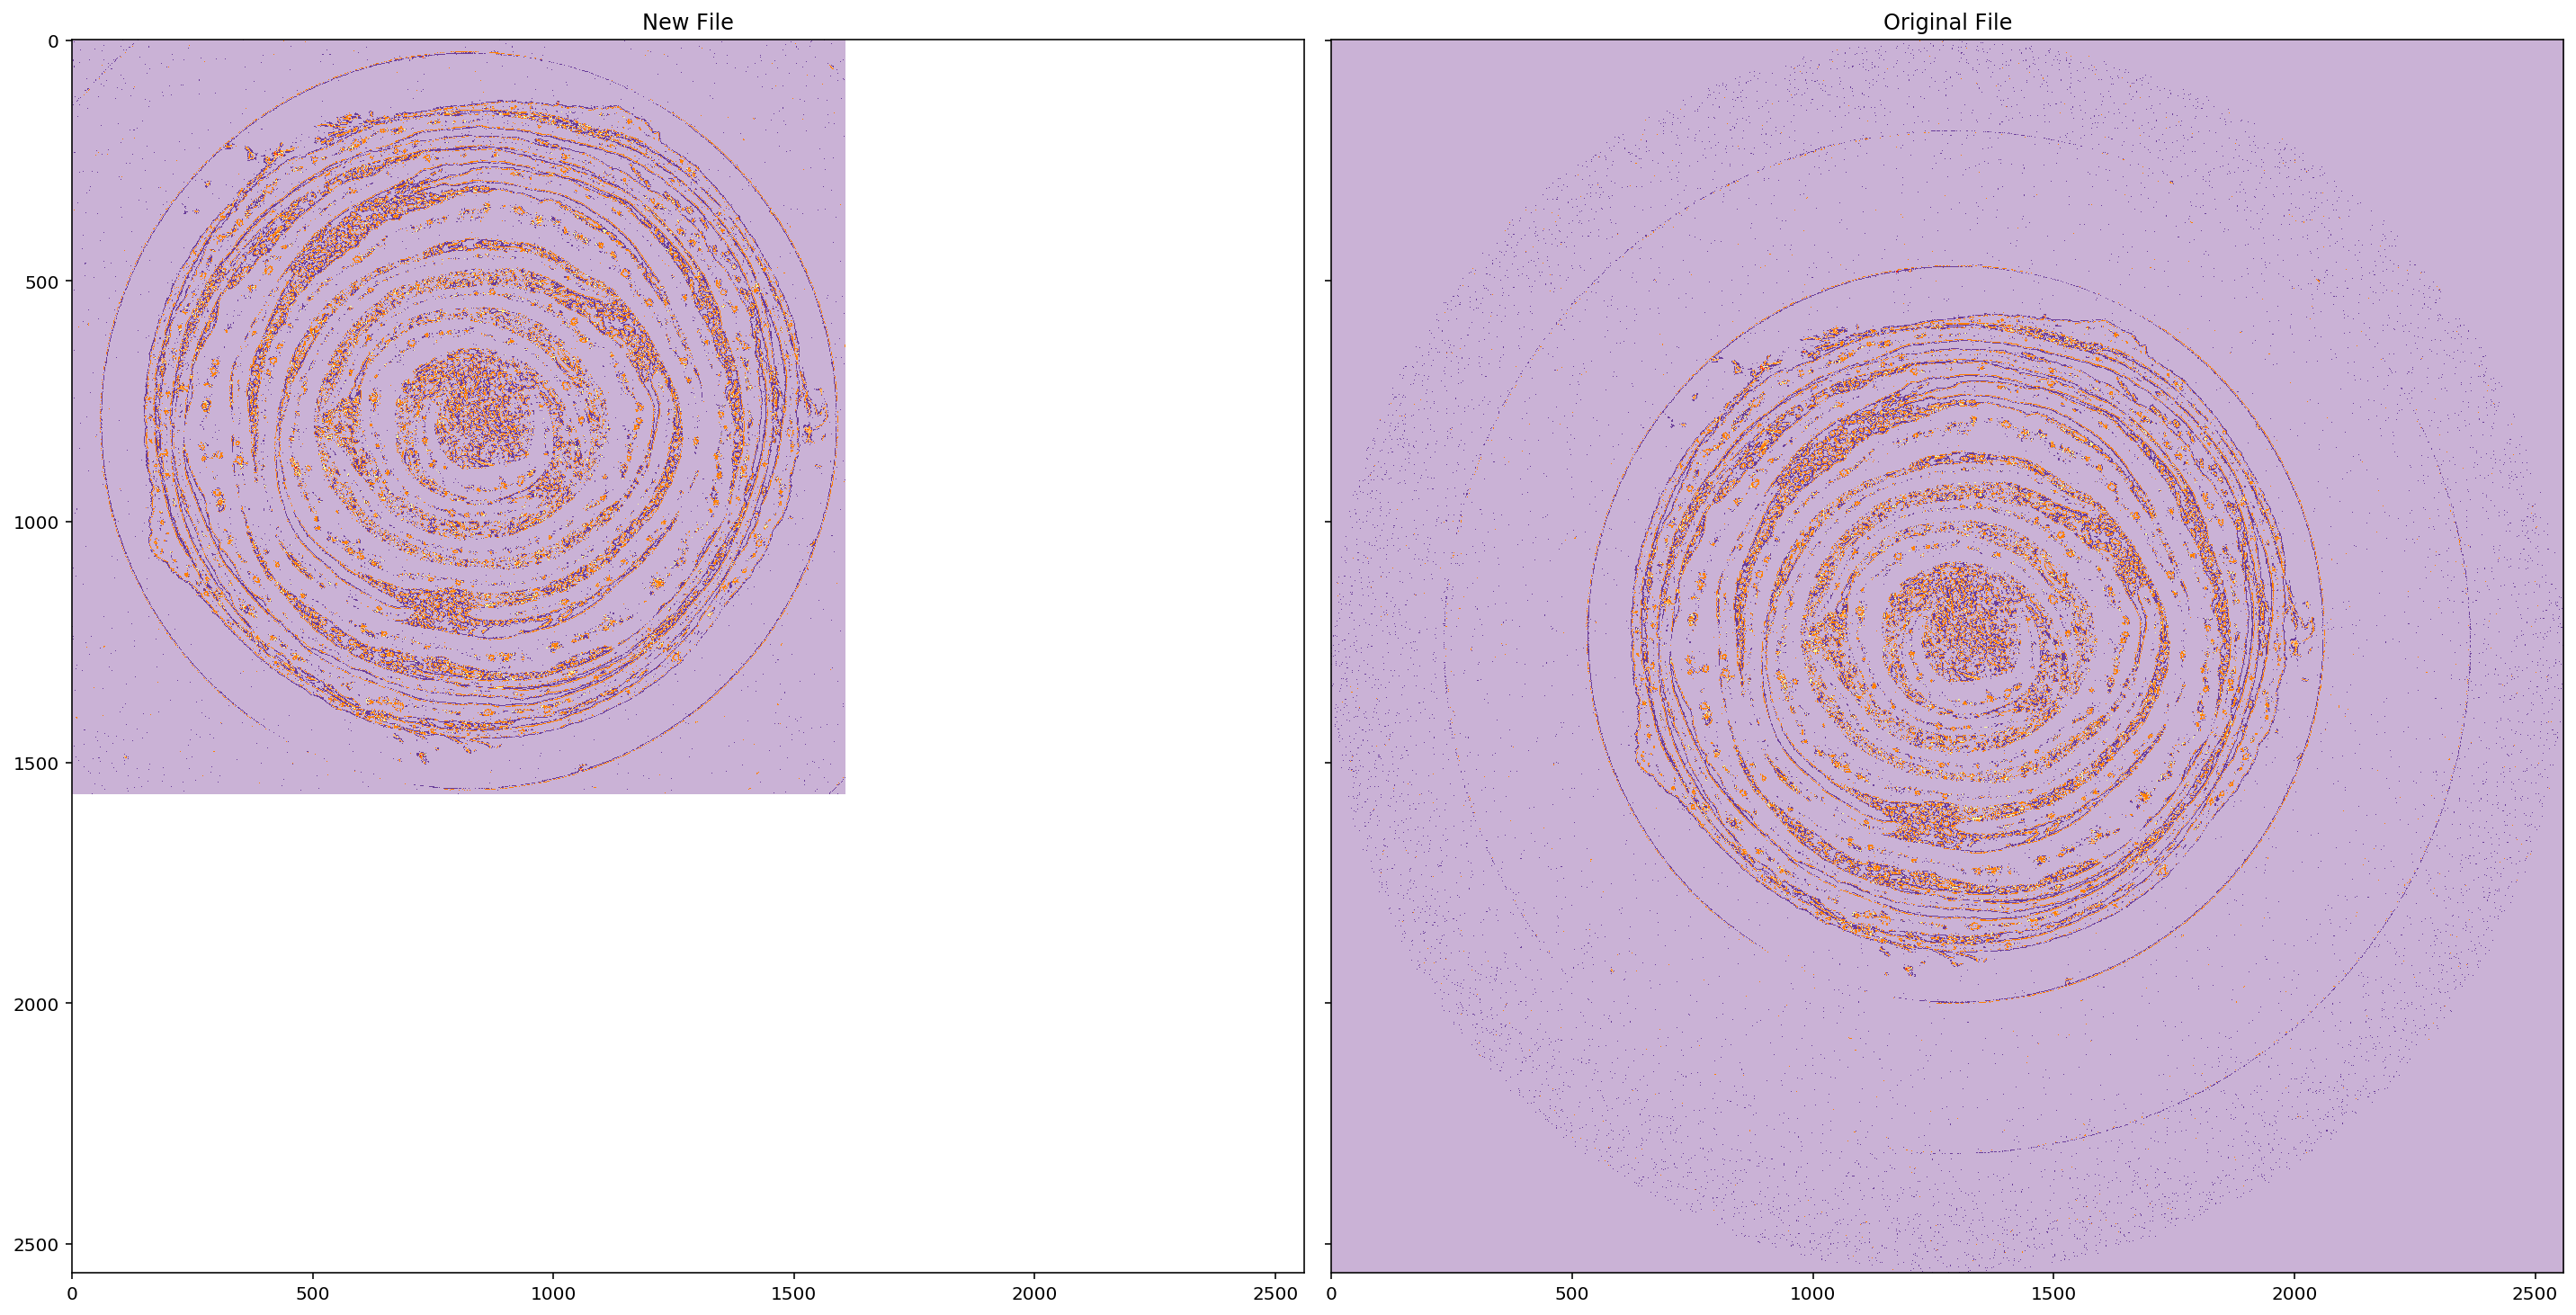

In [2]:
#Semi-autonomous Stack Cropping Tool

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import skimage as sk
import pandas as pd
import skimage.data as data
import skimage.segmentation as seg
from skimage import filters, transform, io, draw, color, exposure, img_as_float, img_as_ubyte
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os
import csv
#Defines region of interest
def circle_points(resolution, center, radius):
    """
    Generate points defining a circle on an image.
    """
    radians = np.linspace(0, 2*np.pi, resolution)

    c = center[1] + radius*np.cos(radians)
    r = center[0] + radius*np.sin(radians)
    
    return np.array([c, r]).T


#**********Enter the name of the folder you want to read into dir_nam; the program will automatically make a new folder 
#          with the same name appended with "_cropped"

dir_nam="Buds 2"

#**********Enter the the image number you want to view from the input and output stack; this will allow you to see how
#          much of the original image was cropped, if the images align, or if any errors occured.

file_number=8

#semi-supervised sample cropping-cropping bounds are set to the limit of the field of view
#cropping bounds are modifiable

def active_contour_crop(directn, alpha_level=0.1, beta_level=0.3):
  # Initialize coordinates position to save as a list
  coordinates_list = []

  #sets maximum bounds of cropping
  xcropminglobal=1280
  xcropmaxglobal=1280
  ycropminglobal=1280
  ycropmaxglobal=1280

  for filename in os.listdir(directn):
    #makes new directory called "(directory name here) + cropped"
    new_dir_name=directn+'_cropped'
    if not os.path.exists(new_dir_name):
      os.makedirs(new_dir_name)
    #image is read from directory to system  
    image=io.imread(directn+'/'+filename)
    #can be modifidied for use with rgb stacks using color.rgb2gray(image) statement
    bud1 =image
    #filters are used to help find edges; these are modifiable
    bud = filters.scharr(bud1)
    #image is rescaled to 1/8th size to decrease active contour cropping time
    bud_sml = transform.rescale(bud, scale=0.125) 
    # Exclude last point because a closed path should not have duplicate points
    #We divide by 8 to account for the rescaling factor
    points = circle_points(100, [1280/8, 1280/8], 1200/8)[:-1]
    #snake how we get our sample location data from the images; it references the filtered transformed file,
    #the search area previously defined, and sets the alpha level to whatever the user previously defined it as
    snake = seg.active_contour(bud_sml, points, alpha=alpha_level)
    #again, we have to account for the 1/8 scaling factor
    xsnake=8*snake[:, 0] 
    ysnake=8*snake[:, 1]
    #here the minimum and maximum x&y values are displayed and compared to the global maximum values.
    xcropmin=int(xsnake.min())
    xcropmax=int(xsnake.max())
    ycropmin=int(ysnake.min())
    ycropmax=int(ysnake.max())
    if xcropminglobal>xcropmin:
      xcropminglobal=xcropmin
    if xcropmaxglobal<xcropmax:
      xcropmaxglobal=xcropmax 
    if ycropminglobal>ycropmin:
      ycropminglobal=ycropmin
    if ycropmaxglobal<ycropmax:
      ycropmaxglobal=ycropmax
  #The order of the y min/max and x min/max attributes are defined here for iterative saving
    coordinates = [ycropmin, ycropmax, xcropmin, xcropmax]
# Appends coordinates information for each new picture.
    coordinates_list.append(coordinates)
    #Outputs coordinate list
  return coordinates_list
  
coordinates_list=active_contour_crop(directn=dir_nam, alpha_level=0.3, beta_level=0.3)
#Converts coordinates list to np array
gcd=np.array(coordinates_list) # put coordinate_list here
#Define array information
ygmin=gcd[:,0]
ygmax=gcd[:,1]
xgmin=gcd[:,2]
xgmax=gcd[:,3]
#  The interger value of the mean of the y min/max and x min/max are defined here. Other types of numerical analysis are possible at this step
#  Consider using other values such as the median values
ys=np.int(np.mean(ygmin))
yt=np.int(np.mean(ygmax))
xs=np.int(np.mean(xgmin))
xt=np.int(np.mean(xgmax))
# The cropping function is defined here and as is the directory for the cropped image
def crop(directn):
  for filename in os.listdir(directn):
    new_dir_name=directn+'_cropped'
    if not os.path.exists(new_dir_name):
      os.makedirs(new_dir_name)
    image=io.imread(directn+'/'+filename)
    imagecropped=(image[ys:yt, xs:xt])
    io.imsave(new_dir_name+'/'+filename,imagecropped)
# This activates the crop function on a specific folder.
crop(dir_nam)
# Output of the original and cropped images is coded here
# Specifically in this code block, the location of the input and output images is assigned based on the original file inputs.
dirname=dir_nam
dirnamee=os.listdir(dirname)
newdirname=dirname+'_cropped'
newdirnamee=os.listdir(newdirname)

newfile=io.imread(newdirname +'/' + newdirnamee[file_number])
originalfile=io.imread(dirname +'/' + dirnamee[file_number])
#Used to define number of images displayed and forces them to share axes. The resolution and figure size is tunable
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True,
                         figsize=(20, 20))

axes[0].imshow(newfile, cmap='Paired_r')
axes[0].set_title('New File')

axes[1].imshow(originalfile, cmap='Paired_r')
axes[1].set_title('Original File')


plt.tight_layout()
plt.show()